# Jonathan Halverson
# Sunday, April 3, 2016
# Iris data set

In this notebook we consider the famous iris data set that is available in scikit-learn. We analyze the data and then create a simple classifier to predict the type of iris based on new feature vectors.

In [1]:
import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')

In [2]:
from sklearn.datasets import load_iris
iris = load_iris()
print type(iris)
print iris.keys()

<class 'sklearn.datasets.base.Bunch'>
['target_names', 'data', 'target', 'DESCR', 'feature_names']


### Data preparation

In [3]:
df = pd.DataFrame(iris.data, columns=['s_len', 's_wdt', 'p_len', 'p_wdt'])
df['species'] = iris.target
df.head()

,s_len,s_wdt,p_len,p_wdt,species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


### Data analysis

Now that the data has been cleaned, in this section we perform various calculations and construct plot to get a sense of the data. To check for collinearity we compute the correlation matrix:

In [4]:
df.ix[:,0:4].corr()

,s_len,s_wdt,p_len,p_wdt
s_len,1.000000,-0.109369,0.871754,0.817954
s_wdt,-0.109369,1.000000,-0.420516,-0.356544
p_len,0.871754,-0.420516,1.000000,0.962757
p_wdt,0.817954,-0.356544,0.962757,1.000000


We can view similar information by looking at the pair plots using Seaborn:

In [5]:
#sns.pairplot(df.ix[:,0:4], kind='reg', size=3.5, aspect=4/3.0)

We see that three pairs of predictors have an absolute value of the correlation of greater than 0.8. We must keep this in mind for certain ML models. Next we look at descriptive statistics for each of the three species in the form of box plots:

(0, 3)

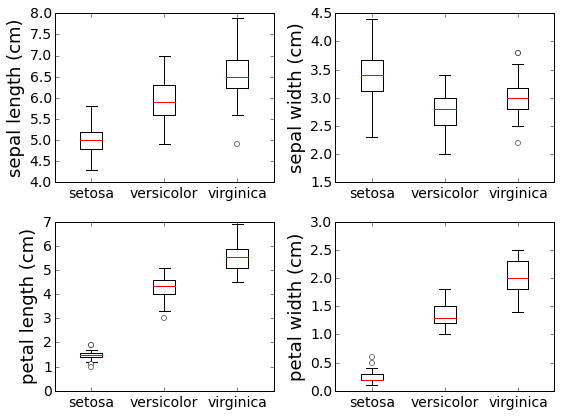

In [6]:
fprops = dict(marker='o', mfc='w', mec='k', markersize=5, linestyle='none', lw=1)
bprops = dict(color='k')
wprops = dict(color='k', linestyle='-', lw=1)
f, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2)
for i in range(4):
    exec('ax' + str(i) + '.boxplot([df[df.species == 0].ix[:,'+ str(i) + '], df[df.species == 1].ix[:,' + str(i) + '], df[df.species == 2].ix[:,' + str(i) + ']], labels=iris.target_names, flierprops=fprops, boxprops=bprops, whiskerprops=wprops)') 
    exec('ax' + str(i) + '.set_ylabel(iris.feature_names[' + str(i) + '])')
plt.tight_layout()
ax1.set_ylim(1.5, 4.5)
ax2.set_ylim(0, 7)
ax3.set_ylim(0, 3)

We see that setosa can be identified by having a small petal length and width. Similarly, versicolor and virginica have non-overlapping IQR's for both petal properties. This suggests that a good classification model can be constructed. However, the three species cannot be completely distinguished from one another. Let's try forming the product of the four features since virginica is consistently higher than versicolor.

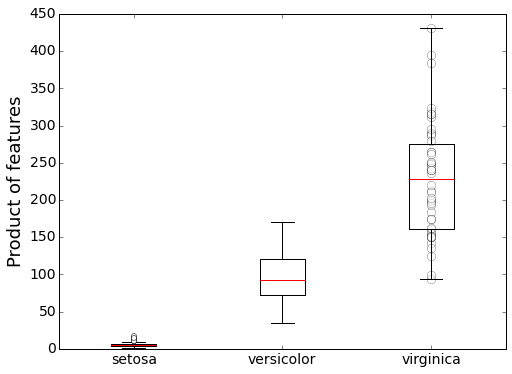

In [7]:
fprops = dict(marker='o', mfc='w', mec='k', markersize=5, linestyle='none')
bprops = dict(color='k')
wprops = dict(color='k', linestyle='-', lw=1)
df['prod'] = df.s_len * df.s_wdt * df.p_len * df.p_wdt
plt.plot(df[df.species == 2]['prod'].size * [3], df[df.species == 2]['prod'], 'wo', alpha=0.5)
plt.boxplot([df[df.species == 0]['prod'], df[df.species == 1]['prod'], df[df.species == 2]['prod']], labels=iris.target_names, flierprops=fprops, boxprops=bprops, whiskerprops=wprops)
plt.ylabel('Product of features')

This simple new feature is not enough to distinguish the groups. A more complicated transformation is necessary or, more likely, the complete separation may not be possible at all.

Let's ignore the targets and try to plot the data in a way that reveals three distinct clusters. Domain knowledge on plants would be useful here since there may be a combination of features that brings about the separation. Let's try area and then aspect ratio.

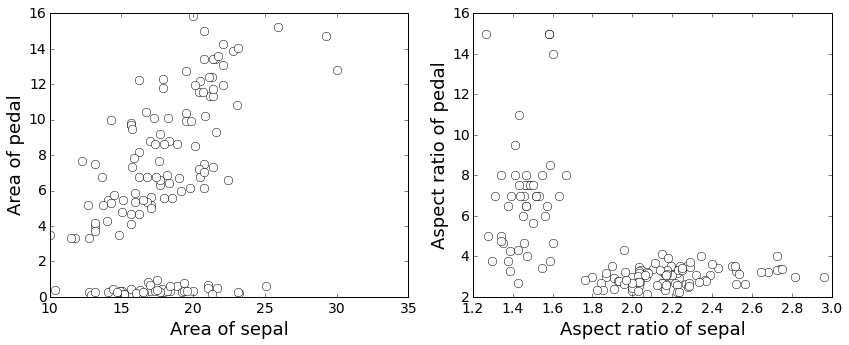

In [8]:
f, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax0.plot(df.s_len * df.s_wdt, df.p_len * df.p_wdt, 'wo')
ax1.plot(df.s_len / df.s_wdt, df.p_len / df.p_wdt, 'wo')
ax0.set_xlabel('Area of sepal')
ax0.set_ylabel('Area of pedal')
ax1.set_xlabel('Aspect ratio of sepal')
ax1.set_ylabel('Aspect ratio of pedal')
plt.tight_layout()

These two simple plots do not separate into three distinct clusters. It may be that there is no transformation that will do this.

### Classifier

Let's create a classification model using k-nearest neighbors. This is a simple method which makes predictions based on the class of the new points immediate neighbors. A scheme must be in place to handle ties or when the most frequent neighbors are divided on a class (e.g., R, R, PG, PG, NC-17). One can apply different weights to the k-neighbors as well.

In [9]:
X = iris.data
y = iris.target

In [10]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

The metric used to determine the closest neighbors is the simple Euclidean distance:

In [11]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski')
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=5, p=2, weights='uniform')

Now let's to make predictions for the test sepal and pedal lengths: 

In [12]:
y_pred = knn.predict(X_test)

In [13]:
from sklearn import metrics
print metrics.accuracy_score(y_test, y_pred)

0.95


It is not surprising that perfect accuracy was not found since we showed above that the clusters do not separate completely. One could continue by finding the optimal value of k, doing K-fold cross validation, and trying other models like multinomial logistic regression.